In [1]:
!pip install transformers
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:

#importing necessary libraries
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping
import sklearn
from sklearn.model_selection import train_test_split


In [6]:
#loading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/duttaaadhar/Covid-Policy-Tracker/main/final_clean_dataset.csv')
data = df.drop("Flag", axis='columns')
data['Category'] = data['Category'].map({'C': 0, 'H': 1})
print(data)

                                                  Policy  Category
0       vietnam started reopening schools from 4 may ...         0
1         in the coming two weeks university students...         0
2        on august 16 the saudi arabian ministry of e...         0
3         primary and middle schools and kindergarten...         0
4         primary and middle schools in gansu provinc...         0
...                                                  ...       ...
65771  with effect from 11122020  am until 31122020  ...         1
65772  with kanton obwalden all kantons have now impl...         1
65773  with mtt2prt018 the ecuadorian government issu...         1
65774  with the lifting of the soluthurn minilockdown...         1
65775  yvon deschamps and veronique cloutier tv perso...         1

[65776 rows x 2 columns]


In [10]:

#tokenizing the text
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['Policy'].values)
X = tokenizer.texts_to_sequences(data['Policy'].values)
X = pad_sequences(X, maxlen=100)


In [11]:

#creating the model
model = Sequential()
model.add(Embedding(5000, 128, input_length=X.shape[1]))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(2, activation="softmax"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [12]:

#splitting the dataset into train and test sets
Y = pd.get_dummies(data['Category']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)


In [10]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

#training the model
model.fit(X_train, Y_train, batch_size=32, epochs=3, validation_split=0.2, callbacks=[cp_callback])


Epoch 1/3
1316/1316 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9256
Epoch 1: saving model to training_1/cp.ckpt
1316/1316 [==============================] - 698s 525ms/step - loss: 0.1939 - accuracy: 0.9256 - val_loss: 0.1398 - val_accuracy: 0.9488
Epoch 2/3
1316/1316 [==============================] - ETA: 0s - loss: 0.1184 - accuracy: 0.9587
Epoch 2: saving model to training_1/cp.ckpt
1316/1316 [==============================] - 646s 491ms/step - loss: 0.1184 - accuracy: 0.9587 - val_loss: 0.1389 - val_accuracy: 0.9494
Epoch 3/3
1316/1316 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.9685
Epoch 3: saving model to training_1/cp.ckpt
1316/1316 [==============================] - 694s 527ms/step - loss: 0.0930 - accuracy: 0.9685 - val_loss: 0.1488 - val_accuracy: 0.9460


In [11]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

In [7]:
covmodel = tf.keras.models.load_model('saved_model/my_model')

In [8]:
#predicting the category of a given sentence
sentence = "The government has announced a new policy to help businesses affected by the pandemic"

#tokenizing the sentence
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentence)
X = tokenizer.texts_to_sequences(sentence)
X = pad_sequences(X, maxlen=100)

#predicting the category
prediction = covmodel.predict(X)
if prediction[0][0] > prediction[0][1]:
  print("Category: C")
else:
  print("Category: H")


3/3 [==============================] - 1s 85ms/step
Category: C


In [16]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

#importing necessary libraries
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score

#calculating confusion matrix
y_pred = covmodel.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)
confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])


412/412 [==============================] - 57s 137ms/step


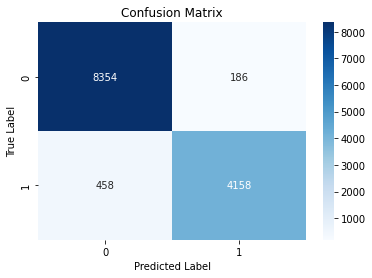

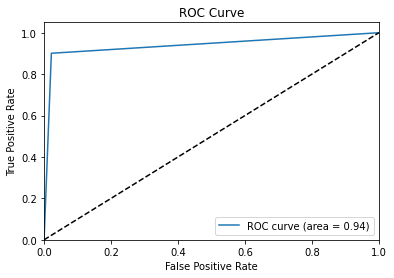

In [18]:

#importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

#visualizing confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#visualizing ROC Curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#define metrics
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [14]:

#calculating ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

#calculating F1 Score
f1_score(y_true, y_pred)


0.9281249999999999

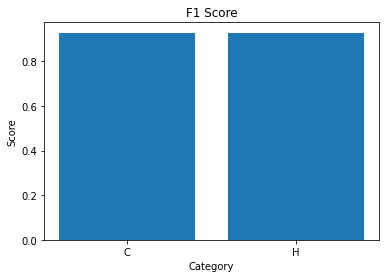

In [19]:
#visualizing F1 Score
plt.bar(['C', 'H'], f1_score(y_true, y_pred))
plt.title('F1 Score')
plt.xlabel('Category')
plt.ylabel('Score')
plt.show()